In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from matplotlib import rc
rc('animation', html='jshtml')
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from utils import get_data_per_anchor, spatial_plot
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import os
import warnings
from micromlgen import port
import m2cgen as m2c
from matplotlib import pyplot as plt
from matplotlib import colors
from adapt.feature_based import FA
from adapt.instance_based import TrAdaBoostR2
warnings.filterwarnings("ignore")

In [113]:
params = {
    "test_size":0.33,
    "random_state":42,
    "splits":3,
    
}

In [114]:
df = pd.read_pickle("raw_IQ.pkl")
df.sort_values(['point', 'anchor', 'room', 'channel'], inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [115]:
def iq_processing(data):
    
    """
    Input: Data
    Output: Processed Data

    Processing: Power Scaling, IQ shifting
    """

    cols_real = ['pdda_input_real_{}'.format(x+1) for x in range(5)]
    cols_imag = ['pdda_input_imag_{}'.format(x+1) for x in range(5)]

    iq_values = pd.DataFrame(data['pdda_input_real'].tolist(), columns=cols_real, index=data.index)
    iq_values[cols_imag] = pd.DataFrame(data['pdda_input_imag'].tolist(), columns=cols_imag, index=data.index)
    
    phase = pd.DataFrame(np.arctan2(iq_values['pdda_input_imag_1'],iq_values['pdda_input_real_1']), columns=['phase_1'])
    
    cos = np.cos(phase).values.ravel()
    sin = np.sin(phase).values.ravel()
    
    out = data.copy()
    iq_ref = np.abs(iq_values[f'pdda_input_real_1']*cos + iq_values[f'pdda_input_imag_1']*sin)
    for i in range(1,6):
        out[f'pdda_input_real_{i}'] = (iq_values[f'pdda_input_real_{i}']*cos + iq_values[f'pdda_input_imag_{i}']*sin)
        out[f'pdda_input_imag_{i}'] = (-iq_values[f'pdda_input_real_{i}']*sin + iq_values[f'pdda_input_imag_{i}']*cos)
        iq_ref +=  iq_values[f'pdda_input_real_{i}']**2 + iq_values[f'pdda_input_imag_{i}']**2

    power_norm =  StandardScaler().fit_transform((out['reference_power'] + out['relative_power']).values.reshape(-1,1))/10
    
    out.insert(25, 'power', power_norm)
    out.insert(24, 'iq_ref', iq_ref)
    out.drop(columns=['pdda_input_imag_1', 'pdda_input_real', 'pdda_input_imag'], inplace=True)
    return out

In [116]:
features = ['power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4',
           'pdda_input_real_5', 'pdda_input_imag_5']
# theta does not change, make predictions for phi only, azimuth angles 
# predict only for phi, 
targets = ['true_phi']
location = ['x_tag', 'y_tag']
pdda_angle = ['pdda_phi']
point = ['point']

In [117]:
new_features = ['power_37', 'pdda_input_real_1_37', 'pdda_input_real_2_37', 'pdda_input_imag_2_37', 'pdda_input_real_3_37', 'pdda_input_imag_3_37', 'pdda_input_real_4_37', 'pdda_input_imag_4_37',
               'pdda_input_real_5_37', 'pdda_input_imag_5_37','power_38', 'pdda_input_real_1_38', 'pdda_input_real_2_38', 'pdda_input_imag_2_38', 'pdda_input_real_3_38', 'pdda_input_imag_3_38',
                        'pdda_input_real_4_38', 'pdda_input_imag_4_38','pdda_input_real_5_38', 'pdda_input_imag_5_38',
                       'power_39', 'pdda_input_real_1_39', 'pdda_input_real_2_39', 'pdda_input_imag_2_39', 'pdda_input_real_3_39', 'pdda_input_imag_3_39',
                        'pdda_input_real_4_39', 'pdda_input_imag_4_39','pdda_input_real_5_39', 'pdda_input_imag_5_39']

In [118]:
def scale(df):
    """scale dataset with mean=0, std=1"""
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

In [119]:
def select_polarity(df):
    """"rssi signals closer to 0, represent the better quality of signal"""
    tmp = df.sort_values(['point', 'anchor', 'channel', 'room'])
    tmp['mask'] = tmp['reference_power'] + df['relative_power']
    tmp = tmp.sort_values(['point', 'anchor', 'channel', 'room', 'mask'])
    tmp = tmp.drop_duplicates(subset=['point', 'anchor', 'channel', 'room'], keep='last')
    return tmp

In [120]:
def select_random_channel(df):
    mid_concrete_random = pd.DataFrame()
    for room in df.room.unique():
        room_df = df.loc[df['room'] == room]
        for anchor in df.anchor.unique():
            anchor_df = room_df.loc[room_df['anchor'] == anchor]
            grouped = anchor_df.groupby(['point'],as_index=False)
            for group, tdf in grouped:
                random_selection = tdf.sample(n=1,random_state=42)
                mid_concrete_random = pd.concat([mid_concrete_random, random_selection])
    return mid_concrete_random

In [121]:
# cols = ['element1','element2','element3','element4','element5']

def combine_features(df):
    grouped = df.groupby(['room','anchor', 'point'],as_index=False)
    new_features = ['power_37', 'pdda_input_real_1_37', 'pdda_input_real_2_37', 'pdda_input_imag_2_37', 'pdda_input_real_3_37', 'pdda_input_imag_3_37', 'pdda_input_real_4_37', 'pdda_input_imag_4_37',
               'pdda_input_real_5_37', 'pdda_input_imag_5_37','power_38', 'pdda_input_real_1_38', 'pdda_input_real_2_38', 'pdda_input_imag_2_38', 'pdda_input_real_3_38', 'pdda_input_imag_3_38',
                        'pdda_input_real_4_38', 'pdda_input_imag_4_38','pdda_input_real_5_38', 'pdda_input_imag_5_38',
                       'power_39', 'pdda_input_real_1_39', 'pdda_input_real_2_39', 'pdda_input_imag_2_39', 'pdda_input_real_3_39', 'pdda_input_imag_3_39',
                        'pdda_input_real_4_39', 'pdda_input_imag_4_39','pdda_input_real_5_39', 'pdda_input_imag_5_39']
    x_loc = []
    y_loc = []
    pts = []
    pdda = []
    anchors = []
    pdda = []
    true_phi = []
    room = []
    combined_features = []
    temp = pd.DataFrame()
    for group, tdf in grouped:
        soi_matrix = tdf[features]
        # print(soi_matrix)
        soi_matrix = soi_matrix.values.reshape(1,30)
        # print(soi_matrix[0])
        # break
        x_loc.append(tdf['x_tag'].values[0])
        y_loc.append(tdf['y_tag'].values[0])
        pts.append(tdf['point'].values[0])
        anchors.append(tdf['anchor'].values[0])
        pdda.append(tdf['pdda_phi'].values[0])
        room.append(tdf['room'].values[0])
        combined_features.append(soi_matrix[0])
        true_phi.append(tdf['true_phi'].values[0])

    temp[new_features] = combined_features
    temp['true_phi'] = true_phi
    temp['pdda_phi'] = pdda
    temp['anchor'] = anchors
    temp['point'] = pts
    temp['x_tag'] = x_loc
    temp['y_tag'] = y_loc
    temp['room'] = room
    return temp

In [199]:
def train(df, df_test, models, metrics):
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    x_loc = []
    y_loc = []
    anchor_val = []
    pts = []
    m_preds = {}
    flag = True
    trained_models = {}
    for model in models:
        print(str(model))
        for anchor in [4.0]:
            temp = pd.DataFrame()
            anchor_df = df.loc[df['anchor'] == anchor]
            anchor_test_df = df_test.loc[df_test['anchor'] == anchor]
            X = anchor_df[new_features].values
            y = anchor_df[targets].values
            X_train = X
            y_train = y
            X_test = anchor_test_df[new_features].values
            y_test = anchor_test_df[targets].values
            
            test_location = anchor_test_df[location].values
            pdda_result = anchor_test_df[pdda_angle].values
            points = anchor_test_df[point].values

            # learn the trainer on the train set and apply for testing set
            regr = model
            regr.fit(X_train,y_train)
            if str(model)+'_anchor'+str(int(anchor)) not in trained_models:
                if str(model).split("(")[0] != "XGBRegressor":
                    trained_models[str(model)+'_anchor'+str(int(anchor))] = regr
                else:
                    trained_models["XGBRegressor"+'_anchor'+str(int(anchor))] = regr
            # trained_models.append(regr)
            predictions = regr.predict(X_test)
            # need pointwise error for plotting using spatial_plot function
            # errors = []
            avg_mae = []
            # print(len(predictions))
            # print(pdda_result.shape)
            # temp = []
            for i in range(len(predictions)):
                model_preds.append(predictions[i])
                # predictions.append(mean_absolute_error(y_test[i], temp))
                pdda_preds.append(pdda_result[i][0])
                true_phi.append(y_test[i][0])
                x_coordinate, y_coordinate = test_location[i]
                pts.append(points[i][0])
                x_loc.append(x_coordinate)
                y_loc.append(y_coordinate)
                anchor_val.append(anchor)
        # print(pdda_preds)
        if flag:
            temp['pdda'] = pdda_preds
            temp['true_phi'] = true_phi
            temp['x_loc'] = x_loc
            temp['y_loc'] = y_loc
            temp['point'] = pts
            temp['anchor'] = anchor_val
            results = pd.concat([results, temp])
            flag = False
            
        model_name = str(model).split("(")[0]
        if model_name != 'XGBRegressor':
            model_name = str(model)
        m_preds[model_name] = model_preds
        model_preds = []
        pdda_preds = []
        true_phi = []
        x_loc = []
        y_loc = []
        pts = []
        anchor_val = []
        # results = pd.concat([results, temp])
    for k,v in m_preds.items():
        results[k] = v
        
    return (results, trained_models)

In [200]:
models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10),   
          DecisionTreeRegressor(),  KNeighborsRegressor(), MLPRegressor(), SVR(), GradientBoostingRegressor(),xgb.XGBRegressor(),LinearRegression()]
metrics = [mean_absolute_error, r2_score]

In [201]:
no_f = df[df['room'] == 'testbench_01']
no_f = iq_processing(no_f)
no_f = scale(no_f)
no_f = select_polarity(no_f)
no_f = combine_features(no_f)

In [202]:
low = df[df['room'] == 'testbench_01_furniture_low']
low = iq_processing(low)
low = scale(low)
low = select_polarity(low)
low = combine_features(low)

In [203]:
mid = df[df['room'] == 'testbench_01_furniture_mid']
mid = iq_processing(mid)
mid = scale(mid)
mid = select_polarity(mid)
mid = combine_features(mid)

In [204]:
high = df[df['room'] == 'testbench_01_furniture_high']
high = iq_processing(high)
high = scale(high)
high = select_polarity(high)
high = combine_features(high)

In [330]:
def calculate_mae_errors(results):
    # calculate average mae errors over all anchors
    grouped = results.groupby(['point','anchor'],as_index=False)
    avg_errors = pd.DataFrame()

    for group, tdf in grouped:
        p_df = pd.DataFrame()
        maes_pdda = []
        maes_rf100 = []
        maes_rf10 = []
        maes_svr = []
        maes_lr = []
        
        maes_xgboost = []
        maes_dt = []
        x_locs = []
        y_locs = []
        maes_pdda.append(mean_absolute_error([np.mean(tdf['pdda'].values)], [tdf['true_phi'].values[0]]))

        # maes_rf100.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor()'].values)], [tdf['true_phi'].values[0]]))
        # maes_rf10.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor(n_estimators=10)'].values)], [tdf['true_phi'].values[0]]))
        # maes_svr.append(mean_absolute_error([np.mean(tdf['SVR()'].values)], [tdf['true_phi'].values[0]]))
        maes_xgboost.append(mean_absolute_error([np.mean(tdf['XGBRegressor'].values)], [tdf['true_phi'].values[0]]))
        # maes_dt.append(mean_absolute_error([np.mean(tdf['DecisionTreeRegressor()'].values)], [tdf['true_phi'].values[0]]))
        # maes_lr.append(mean_absolute_error([np.mean(tdf['LinearRegression()'].values)], [tdf['true_phi'].values[0]]))
        x_locs.append(tdf['x_loc'].values[0])
        y_locs.append(tdf['y_loc'].values[0])

        p_df['MAE_pdda'] = maes_pdda
        # p_df['MAE_LR'] = maes_lr
        # p_df['MAE_SVR'] = maes_svr
        # p_df['MAE_DT'] = maes_dt
        
        # p_df['MAE_RF10'] = maes_rf10
        
        p_df['MAE_XGBoost'] = maes_xgboost

        # p_df['MAE_RF100'] = maes_rf100
        p_df['x_loc'] = x_locs
        p_df['y_loc'] = y_locs

        avg_errors = pd.concat([avg_errors, p_df])
    return avg_errors
            


In [41]:
# results, trained_models = train(no_f, low, models, metrics)

In [42]:
trained_models

NameError: name 'trained_models' is not defined

In [45]:
rf10 = trained_models['RandomForestRegressor(n_estimators=10)_anchor1.0']

In [44]:
from sklearn.model_selection import train_test_split

In [70]:
models_names = ['MAE_pdda','MAE_RF100','MAE_XGBoost', 'MAE_DT']
res = {}
room = ['No Furniture', 'Low Furniture', 'Mid Furniture','High Furniture']
models = [DecisionTreeRegressor()]
anchor_mae = []
individual = pd.read_pickle('results/multichannel.pkl')
for i in range(len(room)):
    for j in range(len(room)):
        if i==j:
            if room[i] == 'No Furniture':
                train_room, test_room = train_test_split(no_f, test_size=0.33)
                
                # mae = individual.loc['RF10', 'testbench_01']
            elif room[i] == 'Low Furniture':
                train_room, test_room = train_test_split(low, test_size=0.33)
                # mae = individual.loc['RF10', 'testbench_01_furniture_low']
            elif room[i] == 'Mid Furniture':
                train_room, test_room = train_test_split(mid, test_size=0.33)
                # mae = individual.loc['RF10', 'testbench_01_furniture_mid']
            else:
                train_room, test_room = train_test_split(high, test_size=0.33)
                # mae = individual.loc['RF10', 'testbench_01_furniture_high'] 
                
            # if room[i] not in res:
            #     res[room[i]] = [mae]
            # else:
            #     res[room[i]].append(mae)
                
            results, trained_models = train(train_room, test_room, models, metrics)
            for k,v in trained_models.items():
                anchor = k[-1]
                # print(anchor)
                source = train_room.loc[train_room['anchor'] == float(anchor)]
                target = test_room.loc[test_room['anchor'] == float(anchor)]
                # print(target.shape[0])
                # break

                Xs = source[new_features].values
                ys = source[targets].values


                Xt = target[new_features].values
                yt = target[targets].values

                samples = 100
                tgt_index_lab_ = np.random.choice(target.shape[0], samples,replace=False)
                Xt_lab = Xt[tgt_index_lab_]
                yt_lab = yt[tgt_index_lab_]

                Xt = np.delete(Xt, tgt_index_lab_, axis=0)
                yt = np.delete(yt, tgt_index_lab_, axis=0)

                model = TrAdaBoostR2(v, Xt=Xt_lab, yt=yt_lab, random_state=0)
                model.fit(Xs, ys)
                print('mae ' + str(mean_absolute_error(model.predict(Xt).ravel(), yt.ravel())))
                anchor_mae.append(mean_absolute_error(model.predict(Xt).ravel(), yt.ravel()))

            mae_error = np.mean(anchor_mae)
            anchor_mae = []
            # print(errors)
            # mae_error = np.mean(errors['MAE_RF10'].values) 
            if room[i] not in res:
                res[room[i]] = [mae_error]
            else:
                 res[room[i]].append(mae_error)

            continue
            
            
        
        if room[i] == 'No Furniture':
            train_room = no_f
        elif room[i] == 'Low Furniture':
            train_room = low
        elif room[i] == 'Mid Furniture':
            train_room = mid
        elif room[i] == 'High Furniture':
            train_room = high
            
        if room[j] == 'No Furniture':
            test_room = no_f
        elif room[j] == 'Low Furniture':
            test_room = low
        elif room[j] == 'Mid Furniture':
            test_room = mid
        elif room[j] == 'High Furniture':
            test_room = high
            
        
        results, trained_models = train(train_room, test_room, models, metrics)
        print(trained_models)
        
        for k,v in trained_models.items():
            anchor = k[-1]
            # print(anchor)
            source = train_room.loc[train_room['anchor'] == float(anchor)]
            target = test_room.loc[test_room['anchor'] == float(anchor)]
            # print(target.shape[0])
            # break
            
            Xs = source[new_features].values
            ys = source[targets].values


            Xt = target[new_features].values
            yt = target[targets].values

            samples = 100
            tgt_index_lab_ = np.random.choice(target.shape[0], samples,replace=False)
            Xt_lab = Xt[tgt_index_lab_]
            yt_lab = yt[tgt_index_lab_]

            Xt = np.delete(Xt, tgt_index_lab_, axis=0)
            yt = np.delete(yt, tgt_index_lab_, axis=0)
        
            model = TrAdaBoostR2(v, Xt=Xt_lab, yt=yt_lab, random_state=0)
            model.fit(Xs, ys)
            print('mae ' + str(mean_absolute_error(model.predict(Xt).ravel(), yt.ravel())))
            anchor_mae.append(mean_absolute_error(model.predict(Xt).ravel(), yt.ravel()))
            
        mae_error = np.mean(anchor_mae)
        anchor_mae = []
        # print(errors)
        # mae_error = np.mean(errors['MAE_RF10'].values) 
        if room[i] not in res:
            res[room[i]] = [mae_error]
        else:
             res[room[i]].append(mae_error)
            
        
        
print(anchor_mae)


DecisionTreeRegressor()
Iteration 0 - Error: 0.0242
Iteration 1 - Error: 0.0273
Iteration 2 - Error: 0.1012
Iteration 3 - Error: 0.1786
Iteration 4 - Error: 0.0087
Iteration 5 - Error: 0.0039
Iteration 6 - Error: 0.0049
Iteration 7 - Error: 0.0166
Iteration 8 - Error: 0.0707
Iteration 9 - Error: 0.0796
mae 5.169577874818049
Iteration 0 - Error: 0.0000
Iteration 1 - Error: 0.0048
Iteration 2 - Error: 0.0084
Iteration 3 - Error: 0.0147
Iteration 4 - Error: 0.0043
Iteration 5 - Error: 0.0151
Iteration 6 - Error: 0.1738
Iteration 7 - Error: 0.0108
Iteration 8 - Error: 0.0366
Iteration 9 - Error: 0.5432
mae 4.494310099573258
Iteration 0 - Error: 0.0089
Iteration 1 - Error: 0.0186
Iteration 2 - Error: 0.4215
Iteration 3 - Error: 0.0068
Iteration 4 - Error: 0.0148
Iteration 5 - Error: 0.2613
Iteration 6 - Error: 0.0031
Iteration 7 - Error: 0.1179
Iteration 8 - Error: 0.4355
Iteration 9 - Error: 0.3783
mae 5.921954674220964
Iteration 0 - Error: 0.0000
Iteration 1 - Error: 0.0000
Iteration 2 - 

In [ ]:
models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10),   
          DecisionTreeRegressor(), xgb.XGBRegressor()]

results, trained_models = train(no_f, high, models, metrics)
# print(results)
results['pdda'][results.iloc[:,0] > 50 ] = 50
results['pdda'][results.iloc[:,0] < -50 ] = -50
errors = calculate_mae_errors(results)

In [73]:
transfer.head()

,No Furniture,Low Furniture,Mid Furniture,High Furniture
No Furniture,5.374250,3.124606,4.857126,5.516883
Low Furniture,2.527343,5.263891,4.110226,4.998402
Mid Furniture,4.517490,3.599510,6.272875,4.216052
High Furniture,5.233053,5.333926,3.901896,5.924808


In [74]:
individual = pd.read_pickle('results/multichannel.pkl')
pdda_df = pd.DataFrame()
pdda_df['pdda'] = list(individual.loc['pdda'])
pdda_df.rename(columns = {0: ''}, inplace = True)

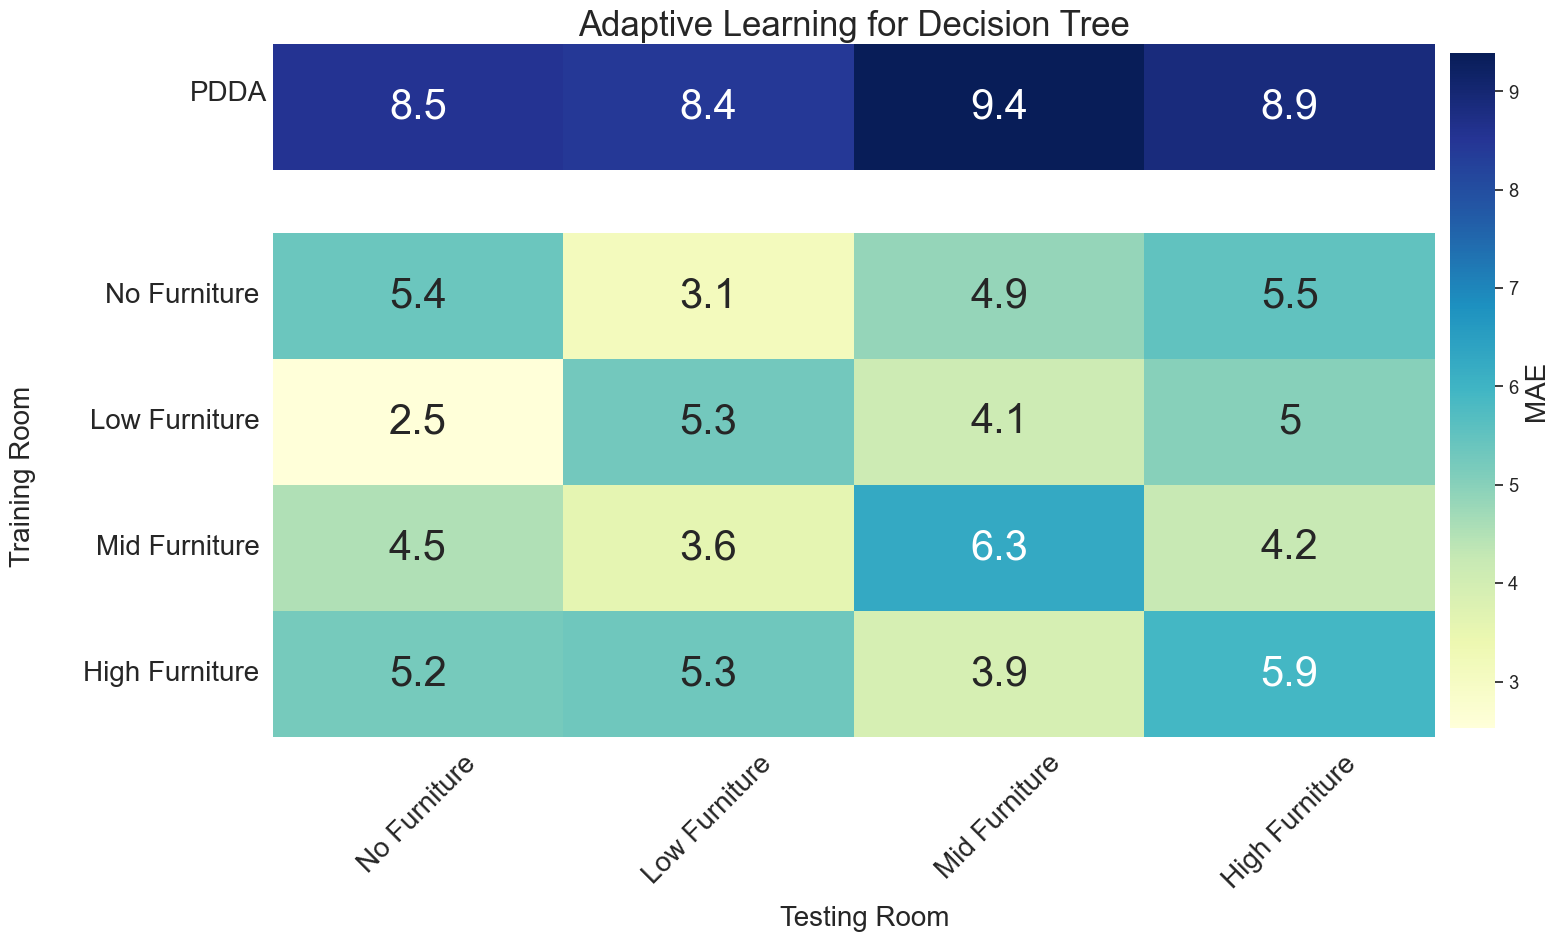

In [75]:

fig, ax = plt.subplots(2,1, sharex=True, figsize=(15,9), gridspec_kw={'height_ratios': [1,4]})
cbar_ax = fig.add_axes([.91, .12, .03, .75])
vmax = np.max(pdda_df)
vmin = np.min(transfer.values)
sns.heatmap(pdda_df['pdda'].values.reshape(4,1).T,annot=True, annot_kws={"size": 30}, cmap="YlGnBu", vmax = vmax, vmin = vmin, cbar_ax = cbar_ax,ax=ax[0], xticklabels=False, yticklabels=False)
sns.heatmap(transfer, annot=True, annot_kws={"size": 30}, cbar=False, vmax = vmax, vmin = vmin, cmap="YlGnBu", cbar_ax = None, ax=ax[1])
ax[0].set_ylabel('PDDA', rotation=0, ha='right', fontsize=20)
sns.set(font_scale=1.2)
fig.text(0.52, -0.1, 'Testing Room', ha='center', fontsize=20)
fig.text(-0.05, 0.4, 'Training Room', va='center', rotation='vertical',fontsize=20)
cbar_ax.set_ylabel('MAE', fontsize=20)

ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0,fontsize=20) 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center', fontsize=20) 
ax[0].set_title('Adaptive Learning for Decision Tree',fontsize=25)
plt.savefig('figures/Figure5/multichannel/dt',bbox_inches='tight')
plt.savefig('figures/Figure5/multichannel/dt.pdf', bbox_inches='tight')
plt.show()

# fig, ax = plt.subplots(2,1, sharex=True, figsize=(15,9), gridspec_kw={'height_ratios': [1,4]})
# cbar_ax = fig.add_axes([.91, .12, .03, .75])
# vmax = np.max(pdda_df)
# vmin = np.min(transfer.values)
# sns.heatmap(pdda_df['pdda'].values.reshape(4,1).T,annot=True, annot_kws={"size": 20}, cmap="YlGnBu", vmax = vmax, vmin = vmin, cbar_ax = cbar_ax,ax=ax[0], xticklabels=False, yticklabels=False)
# sns.heatmap(transfer, annot=True, annot_kws={"size": 20}, cbar=False, vmax = vmax, vmin = vmin, cmap="YlGnBu", cbar_ax = None, ax=ax[1])
# ax[0].set_ylabel('PDDA', rotation=0, ha='right')
# sns.set(font_scale=1.2)
# fig.text(0.52, -0.1, 'Testing Room', ha='center')
# fig.text(0, 0.4, 'Training Room', va='center', rotation='vertical')
# cbar_ax.set_ylabel('MAE', fontsize=14)

# ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0) 
# ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center') 
# ax[0].set_title('Adaptive Learning for Decision Tree')
# # plt.savefig('figures/Figure5/dt',bbox_inches='tight')
# # plt.savefig('figures/Figure5/dt.pdf', bbox_inches='tight')
plt.show()

In [219]:
# list(no_f)

In [162]:
no_f.head()

,anchor,point,x_tag,y_tag,z_tag,los,relative_power,pdda_phi,pdda_theta,pdda_out_az,pdda_out_el,true_phi,true_theta,x_anchor,y_anchor,z_anchor,az_anchor,el_anchor,reference_power,polarity,channel,room,iq_ref,pdda_input_real_1,power,pdda_input_real_2,pdda_input_imag_2,pdda_input_real_3,pdda_input_imag_3,pdda_input_real_4,pdda_input_imag_4,pdda_input_real_5,pdda_input_imag_5,mask
1,1,2,44.1,43.3,1.5,1,-20.5,15.5,8.0,"[0.015950000000000002, 0.01592, 0.01584, 0.015...","[0.03177, 0.03175, 0.03169, 0.0315800000000000...",45.0,-4.1,57.9,43.3,2.5,135,0,-31.9,H,37,testbench_01,0.141616,-0.508723,-0.649547,-0.519346,0.530841,-0.173711,0.714969,0.287223,-0.595289,0.303599,-0.743871,-52.4
2,1,3,44.1,43.5,1.5,1,-21.0,39.0,2.7,"[0.04408, 0.0441, 0.04417, 0.04428000000000001...","[0.014490000000000001, 0.014480000000000002, 0...",44.2,-4.1,57.9,43.3,2.5,135,0,-31.9,H,37,testbench_01,0.158714,-0.259849,-0.761193,-0.133507,0.405483,0.084670,0.573931,-0.484972,-0.651393,-0.384969,-0.110003,-52.9
3,1,4,44.1,43.7,1.5,1,-19.4,34.7,3.3,"[0.05161, 0.05163, 0.05167000000000001, 0.0517...","[0.013280000000000002, 0.01327, 0.013260000000...",43.3,-4.1,57.9,43.3,2.5,135,0,-31.9,H,37,testbench_01,0.191530,-0.100104,-0.403928,0.029190,0.456581,0.169787,0.625607,-0.363294,-0.915662,-0.501829,-0.406370,-51.3
4,1,5,44.1,43.9,1.5,1,-18.2,33.6,4.2,"[0.06705000000000001, 0.06706000000000001, 0.0...","[0.008140000000000001, 0.00813, 0.008100000000...",42.5,-4.1,57.9,43.3,2.5,135,0,-31.9,H,37,testbench_01,0.210453,-0.088008,-0.135980,0.133347,0.531828,0.292550,0.720124,-0.342948,-1.135740,-0.655463,-0.677352,-50.1
5,1,6,44.1,44.1,1.5,1,-16.1,37.3,6.0,"[0.10005000000000001, 0.10008, 0.1001700000000...","[0.018430000000000002, 0.018420000000000002, 0...",41.7,-4.1,57.9,43.3,2.5,135,0,-31.9,H,37,testbench_01,0.275273,0.118211,0.332930,0.198537,0.574435,0.265445,0.852529,-0.395866,-1.622701,-1.282856,-0.914127,-48.0


In [187]:
# list(no_f)

In [334]:
train_room = no_f
test_room = high
train_room = train_room[train_room['anchor'] == 4]
test_room = test_room[test_room['anchor'] == 4]
# print(train_room.shape)
# print(test_room.shape)
# models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10),   
          # DecisionTreeRegressor(), xgb.XGBRegressor()]
models = [xgb.XGBRegressor()]
          # RandomForestRegressor(n_estimators=10),DecisionTreeRegressor(), xgb.XGBRegressor()]

results, trained_models = train(train_room, test_room, models, metrics)
# print(trained_models)
# # print(results)
results['pdda'][results.iloc[:,0] > 50 ] = 50
results['pdda'][results.iloc[:,0] < -50 ] = -50
# errors = calculate_mae_errors(results)
f_results = pd.DataFrame()
temp = pd.DataFrame()
pdda_preds = []
true_phi = []
x_loc =[]
y_loc = []
pts =[]
anchor_val = []
            
for k,v in trained_models.items():
    anchor = k[-1]
    print(anchor)
    source = train_room.loc[train_room['anchor'] == float(anchor)]
    target = test_room.loc[test_room['anchor'] == float(anchor)]
    # print(target.shape[0])
    # break

    Xs = source[new_features].values
    ys = source[targets].values
    

    Xt = target[new_features].values
    pdda_preds = target['pdda_phi'].values
    x_loc = target['x_tag'].values
    y_loc = target['y_tag'].values
    pts = target['point'].values
    yt = target[targets].values

    samples = 100
    tgt_index_lab_ = np.random.choice(target.shape[0], samples,replace=False)
    Xt_lab = Xt[tgt_index_lab_]
    yt_lab = yt[tgt_index_lab_]
    
    # Xt_lab = pd.DataFrame(Xt_lab, columns = list(no_f))
    # Xt_lab = Xt_lab[features].values
    
    Xt = np.delete(Xt, tgt_index_lab_, axis=0)
    yt = np.delete(yt, tgt_index_lab_, axis=0)
    pdda_preds = np.delete(pdda_preds,tgt_index_lab_, axis=0)
    x_loc = np.delete(x_loc,tgt_index_lab_, axis=0)
    y_loc = np.delete(y_loc,tgt_index_lab_, axis=0)
    pts = np.delete(pts,tgt_index_lab_, axis=0)
    

    model = TrAdaBoostR2(v, Xt=Xt_lab, yt=yt_lab, random_state=0)
    model.fit(Xs, ys)
    temp['pdda'] = pdda_preds
    temp['true_phi'] = yt.ravel()
    temp['x_loc'] = x_loc
    temp['y_loc'] = y_loc
    temp['point'] = pts
    temp['anchor'] = 4
    temp['XGBRegressor'] = model.predict(Xt).ravel()
    f_results = pd.concat([f_results, temp])
    print('mae ' + str(mean_absolute_error(model.predict(Xt).ravel(), yt.ravel())))
    # anchor_mae.append(mean_absolute_error(model.predict(Xt).ravel(), yt.ravel()))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
4
Iteration 0 - Error: 0.2444
Iteration 1 - Error: 0.0617
Iteration 2 - Error: 0.0205
Iteration 3 - Error: 0.0121
Iteration 4 - Error: 0.0094
Iteration 5 - Error: 0.0087
Iteration 6 - Error: 0.0072
Iteration 7 - Error: 0.0046
Iteration 8 - Error: 0.0045
Iteration 9 - Er

In [335]:
f_results.head()

,pdda,true_phi,x_loc,y_loc,point,anchor,XGBRegressor
0,-90.0,135.0,44.1,43.3,2,4,81.925125
1,34.7,90.0,44.1,43.5,3,4,49.389015
2,4.0,71.6,44.1,43.7,4,4,35.276394
3,-28.3,63.4,44.1,43.9,5,4,31.538502
4,28.3,59.0,44.1,44.1,6,4,30.340319


In [336]:
f_results['pdda'][f_results.iloc[:,0] > 50 ] = 50
f_results['pdda'][f_results.iloc[:,0] < -50 ] = -50
errors = calculate_mae_errors(f_results)

In [337]:
errors.head()

,MAE_pdda,MAE_XGBoost,x_loc,y_loc
0,185.0,53.074875,44.1,43.3
0,55.3,40.610985,44.1,43.5
0,67.6,36.323606,44.1,43.7
0,91.7,31.861498,44.1,43.9
0,30.7,28.659681,44.1,44.1


In [338]:
errors.describe()

,MAE_pdda,MAE_XGBoost,x_loc,y_loc
count,2347.000000,2347.000000,2347.000000,2347.000000
mean,8.534171,5.071974,50.991010,46.510908
std,11.585625,6.420658,4.057166,2.016357
min,0.000000,0.000456,44.100000,43.100000
25%,1.900000,1.342893,47.500000,44.700000
50%,4.900000,3.200977,50.900000,46.500000
75%,10.600000,6.340613,54.500000,48.300000
max,185.000000,68.758678,57.900000,49.900000


In [339]:
errors['dt_diff'] = errors.apply(lambda row: row['MAE_pdda']- row['MAE_XGBoost'], axis=1, result_type='expand')
# spatial_plot(errors['dt_diff'], errors['x_loc'], errors['y_loc'], 'figures/Figure5/poitwise_adaptive/dt', 'Difference of MAE scores between PDDA and Decision Tree', testing_room='testbench_01_furniture_high_concrete', cmap='RdBu', anchors=[4],vmin=-5,vmax=5)


In [340]:
errors.describe()

,MAE_pdda,MAE_XGBoost,x_loc,y_loc,dt_diff
count,2347.000000,2347.000000,2347.000000,2347.000000,2347.000000
mean,8.534171,5.071974,50.991010,46.510908,3.462197
std,11.585625,6.420658,4.057166,2.016357,10.350913
min,0.000000,0.000456,44.100000,43.100000,-45.961882
25%,1.900000,1.342893,47.500000,44.700000,-0.914127
50%,4.900000,3.200977,50.900000,46.500000,1.450056
75%,10.600000,6.340613,54.500000,48.300000,5.565344
max,185.000000,68.758678,57.900000,49.900000,131.925125


In [341]:
neg = errors['dt_diff'] < -1
pos = errors['dt_diff'] > 1
# neutral = errors['dt_diff'] < -1 and errors['dt_diff'] > 1 

In [342]:
neg.value_counts()

False    1778
True      569
Name: dt_diff, dtype: int64

In [343]:
pos.value_counts()

True     1276
False    1071
Name: dt_diff, dtype: int64

In [344]:
569 + 1778

2347

In [288]:
1197 + 1150

2347

In [109]:
cross_aoanet = [4.8, 4.6, 6, 6.9,
                4.5, 5, 5.3, 5.5,
                5, 5.1, 5.4, 5.2,
                5.3, 5, 5.4, 5.6]
adaptive_aoanet =  [4.7, 4.9, 5.7, 6.2,
                    4.5, 4.7, 5.1, 5.5,
                    5.1, 4.8, 4.9,5.3,
                    5.4, 5.2, 5.1, 5.1]

cross_modified_aoanet = [4.9, 4.9, 6, 6.9,
                        4.6, 5.2, 5.2, 5.6,
                        4.9, 4.9, 5.5, 5.4,
                        5.3, 5.3, 5.1, 5.6,]

adaptive_modified_aoanet = [5.1, 4.8, 5.7, 6.3,
                            4.7, 5.4, 5.2, 5.7,
                            4.9, 5, 5.8, 5.2,
                            5.2, 5.1, 5.1, 5.8]

cross_rf_100_multi = [4.3, 3.3, 4.7, 5.1,
                    3.1, 4.5, 4.2, 4.8,
                    4.1, 3.8, 4.9, 4,
                    4.6, 4.4, 4.1, 4.8]
adaptive_rf100_multi = [4.4, 3.3, 4.6, 5,
                3.1, 4.5, 4.1, 4.6,
                4,3.8, 5.1, 3.9,
                4.5, 4.3, 4.1, 5,]
    
    
cross_rf10_multi = [4.6, 3.6, 5, 5.5,
                    3.4, 4.7, 4.6, 5.1,
                    4.5, 4.1, 5.2, 4.4,
                    5, 4.7, 4.5, 5.1]

adaptive_rf10_multi =  [4.5, 3.3, 4.6, 5.1,
                        3.2, 4.6, 4.2, 4.7,
                        4.1, 3.8, 5, 4,
                        4.6, 4.4, 4.1, 5]

adaptive_xgboost_multi =   [4.4, 2.9, 4.4, 4.8,
                            2.8, 4.6, 3.8, 4.5,
                            3.8, 3.5, 4.8, 3.8,
                            4.5, 4.3, 3.8, 5]

cross_xgboost_multi =  [4.4, 3.1, 4.7, 5.2,
                        3, 4.6, 4.1, 4.7,
                        4.1, 3.7, 5, 4,
                        4.9, 4.6, 4.1, 5]

cross_dt_multi = [5.9, 3.7, 6.1, 6.9,
            3.7, 6.2, 5.2, 6.4,
            5.2, 4.7, 6.7, 5.3,
            6.8, 6.3, 5.4, 6.3]

adaptive_dt_multi = [5.4, 3.1, 4.9, 5.5,
                    2.5, 5.3, 4.1, 5,
                    4.5, 3.6, 6.3, 4.2,
                    5.2, 5.3, 3.9, 5.9]


adaptive_rf100_single = [5.5, 4.2, 5.6, 6.2,
                        4.1, 5.6, 5.1, 5.8,
                        5.2, 4.8, 6, 5.1,
                        5.8, 5.6, 5.1, 6]

cross_rf100_single = [5.4, 4.3, 5.7, 6.3,
                        4.1, 5.6, 5.2, 6,
                        5.3, 4.9, 6, 5.2,
                        5.9, 5.7, 5.2, 5.9]



adaptive_rf10_single = [5.6, 4.3, 5.6, 6.3,
                        4.2, 5.5, 5.2, 6,
                        5.3, 4.9, 5.9, 5.2,
                        6, 5.7, 5.3, 6.1]

cross_rf10_single = [5.6, 4.6, 6, 6.6,
                    4.4, 5.7, 5.6, 6.4,
                    5.7, 5.2, 6.3, 5.6,
                    6.3, 6, 5.6, 6.2]



adaptive_xgboost_single =  [5.6, 4.2, 5.6, 6.1,
                            4, 5.7, 5.1, 5.9,
                            5.2, 4.7, 6.1, 5.2,
                            5.8, 5.6, 5.2, 6]

cross_xgboost_single = [5.6, 4.4, 5.9, 6.6,
                        4.2, 5.8, 5.3, 6.1,
                        5.6, 5.1, 6.2, 5.4,
                        6.2, 5.9, 5.4, 6.3]


adaptive_dt_single =   [6.7, 4.2, 6.7, 7.3,
                        4.1, 7, 5.7, 7.3,
                        6.3, 5.4, 7.4, 5.9,
                        7.1, 6.6, 6.1, 7.]

cross_dt_single =  [6.9, 4.7, 7.1, 8.2,
                    4.6, 7.3, 6.2, 7.8,
                    6.8, 6.1, 7.6, 6.6,
                    7.9, 7.5, 6.7, 7.6 ]


In [110]:
np.mean(np.asarray(adaptive_dt_single))

6.300000000000001

In [111]:
np.mean(np.asarray(cross_dt_single))

6.85

In [97]:
np.mean(np.asarray(cross_modified_aoanet))

5.331250000000001

In [98]:
np.mean(np.asarray(adaptive_modified_aoanet))

5.3125

In [85]:
np.mean(np.asarray(cross_rf_100_multi)) 

4.29375

In [86]:
np.mean(np.asarray(adaptive_rf100_multi)) 

4.26875

In [89]:
np.mean(np.asarray(cross_rf10_multi)) 

4.625

In [88]:
np.mean(np.asarray(adaptive_rf10_multi)) 

4.324999999999999

In [92]:
np.mean(np.asarray(cross_xgboost_multi)) 

4.325

In [91]:
np.mean(np.asarray(adaptive_xgboost_multi)) 

4.106249999999999

In [95]:
np.mean(np.asarray(cross_dt_multi)) 

5.675

In [94]:
np.mean(np.asarray(adaptive_dt_multi)) 

4.66875